# Tópicos de Minería de datos - TP final
## Autora: Aldana Zarate

# Imports

In [ ]:
install.packages("gtools")
install.packages("randomForest")
library(gtools)
library(MASS)
install.packages("kernlab")
library(kernlab)
install.packages("e1071")
library(e1071)
install.packages("caTools")
library(caTools)
install.packages("caret")
library(caret)
library("randomForest")
install.packages("adabag")
library("adabag")

# Parte 1: Preprocesamiento y visualización

En este trabajo se eligió un dataset que contiene 20 variables de diversos factores (psicológicos, fisiológicos, del entorno, académicos y sociales) relacionados al estrés generado sobre los estudiantes. Dicho dataset se puede encontrar [acá](https://www.kaggle.com/datasets/rxnach/student-stress-factors-a-comprehensive-analysis). No se aclara la población fuente de los datos, pero al estar el bullying entre las variables analizadas diría que es sobre estudiantes de secundaria (ya que este es un problema muy presente en la niñez y adolescencia).
Viendo las variables opino que son muy relevantes al problema, ya que al analizar diferentes factores que forman a una persona desde varios aspectos, pueden formar una decisión que tome en consideración todas ellas en conjunto.

## Preprocesamiento

Vamos a proceder ahora a analizar la calidad de los datos. Primero cargamos y verificamos la correcta lectura de los datos.

In [4]:
ss.dataset <- read.csv("StressLevelDataset.csv")
ss.x <- ss.dataset[,-21]
ss.y <- ss.dataset[,21]
head(ss.dataset)

  anxiety_level self_esteem mental_health_history depression headache
1            14          20                     0         11        2
2            15           8                     1         15        5
3            12          18                     1         14        2
4            16          12                     1         15        4
5            16          28                     0          7        2
6            20          13                     1         21        3
  blood_pressure sleep_quality breathing_problem noise_level living_conditions
1              1             2                 4           2                 3
2              3             1                 4           3                 1
3              1             2                 2           2                 2
4              3             1                 3           4                 2
5              3             5                 1           3                 2
6              3             1      

In [ ]:
cat("Número de variables: ", dim(ss.dataset)[2], "\n")
cat("Número de registros: ", dim(ss.dataset)[1], "\n")

Número de variables:  21 
Número de registros:  1100 


Tenemos 20 variables (la última columna, stress_level, es la clase) y 1100 registros. Cubrimos la regla general mínima de 10 registros por variable cómodamente. Son un número considerable de variables, así que puede que un proceso de selección de variables ayude.
Veamos que tan balancedas están las clases:

In [ ]:
cat("--------Stress level-------")
table(ss.dataset[,"stress_level"])

--------Stress level-------
  0   1   2 
373 358 369 


Podemos observar que el dataset se encuentra balanceado entre las clases.
Veamos si hay algun valor faltante:

In [ ]:
na_count <-sapply(ss.dataset, function(y) sum(length(which(is.na(y)))))
data.frame(na_count)

                             na_count
anxiety_level                       0
self_esteem                         0
mental_health_history               0
depression                          0
headache                            0
blood_pressure                      0
sleep_quality                       0
breathing_problem                   0
noise_level                         0
living_conditions                   0
safety                              0
basic_needs                         0
academic_performance                0
study_load                          0
teacher_student_relationship        0
future_career_concerns              0
social_support                      0
peer_pressure                       0
extracurricular_activities          0
bullying                            0
stress_level                        0


Podemos ver que no hay ningún valor faltante entre los datos.
Observando las variables de arriba, no hay ninguna variable que no aporte información (como las que vi en otros datasets como ID o nombre de la persona) con lo cual vamos a dejar todas.
Como se puede observar anteriormente, todas nuestras varibles son numéricas. Al no tener fechas, variables nominales, etc. podemos dejarlas en su versión original.

## Visualización

Procedemos a visualizar las variables para ver si a simple vista hay alguna que llame la atención.

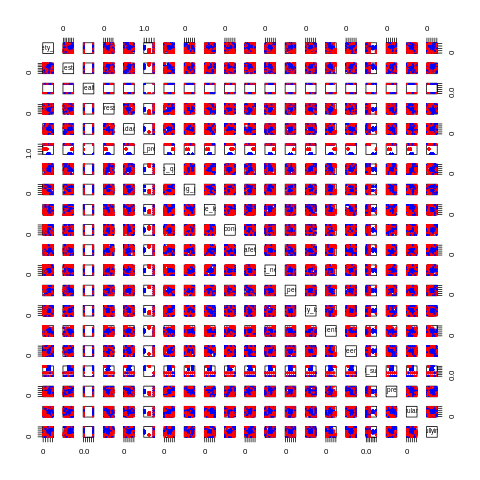

In [79]:
ss.dataset.pairs.plot <- pairs(ss.dataset[, -21], pch = 19, cex = 0.5, col=c("red", "blue")[ss.dataset$stress_level+1])
#output_dir <- "/content/gdrive/My Drive/"
# to <- paste0(output_dir, "analisis_univariado.png")
# png(to, width=6, height=5, units="in", res=1200)
#p
#dev.off()

El gráfico de arriba quedó bastante feo al ser tantas variables (intenté exportarlo a .png para ampliarlo en el código comentado pero no hubo forma). Abriendo la imagen en una nueva pestaña podemos ver que al parecer no hay variables correlacionadas.

# Parte 2: Análisis de variables relevantes

Primero procedemos a hacer una PCA sobre los datos para ver si hay alguna agrupación interesante

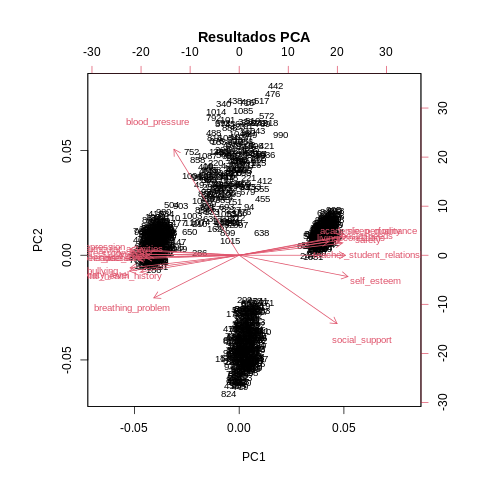

In [7]:
ss.pca <- prcomp(ss.x, scale=TRUE)
biplot(ss.pca,choices=c(1,2),cex=0.8, main='Resultados PCA')

Podemos ver algunas agrupaciones interesantes, como:
- depresión, bullying e historial en salud mental (también se acerca problemas respiratorios)
- relaciones con otros estudiantes y autoestima

Tenemos muchas variables en el dataset, con lo que procedemos a hacer una selección de variables, primero con el método de filtro Kruskal-Wallis para hacer un análisis univariado y luego usaremos el wrapper backward y RFE para un análisis multivariado.

In [25]:
kruskal.ranking <- function(x, y, verbosity = 0){
  max.feat<-dim(x)[2]		#total de features
  ranking <- double(max.feat)
  for (i in 1:max.feat){
    feature <- x[,i]
    ranking[i] <- kruskal.test(feature,y)$statistic
  }

  # Obtenemos las variables
  ranking <- sort(ranking, decreasing=TRUE, index=T)$ix

  # Acomodo con los nombres de las variables ordenadas
  vars.names <- colnames(x)[ranking]


  if(verbosity>1){
		cat("\n---------\nFinal ranking ",max.feat," features.")
		cat("\nFeatures: ",ranking,"\n")
    cat("\nFeatures names: ",vars.names,"\n")
	}

  return(ranking)

}

In [26]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

backward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features sacadas
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: quito la variable con menor error de prediccion, la mando al fondo de la lista (es la menor importante)
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con todas las variables menos la i, entreno un modelo y le mido el error, que lo guardo en class.error[i]
  # i variable que quito
	for(i in 1:max.feat){
		x.train<-x[,-i]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como ultima en mi lista de elegidas (al hacer que baje poco el error es la menos importante).
  #Guardo una lista keep.feat con las que me quedan para seguir quitando.
	list.feat[max.feat]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1] # esto es una lista de indices, ordenadas desde la mas importante a la menos

	if(verbosity>1) cat("\nLeast important feature: ",list.feat[max.feat],"\n")

    #loop principal. A cada paso quito todas las variables disponibles, de a una, le mido el error y saco la de minimo error. Hasta llegar a sacar todas.
	while(num.feat<max.feat-1){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, pruebo de quitarla, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		  features<-keep.feat[-i]
			x.train<-as.matrix(x[,features])
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas avanzando un lugar hacia la izq, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[max.feat-num.feat]<-keep.feat[best.index]
		if(verbosity>2) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

  # La variable que más error genera al sacarla va en la primera posición:

  list.feat[1]<-keep.feat[1]

  # Acomodo los nombres de las variables
  vars.names = colnames(x)[list.feat]

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat+1," features.")
		cat("\nFeatures: ",list.feat,"\n")
    cat("\nFeatures names: ",vars.names,"\n")
	}

 	return(list.feat)

}

In [35]:
#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}

rfe.ranking <- function(x, y, method, verbosity=0, ...){
  max.feat <- dim(x)[2]
  ranking <- double(max.feat) # para guardar los rankings
  actual.features <- 1:max.feat # conjunto donde se van a ir eliminando las variables

  for(i in 1:max.feat){
    x.train <- as.matrix(x[,actual.features])  # variables que vamos a usar en el modelo
    rank <- do.call(method, c(list(x.train, y), list(...)) )

    lowest.rank <- rank$feats[1] # nro de variable con el ranking más bajo

    ranking[max.feat - i + 1] = actual.features[lowest.rank]  # mando al final la variable que menos modifica el modelo
    actual.features <- actual.features[-lowest.rank]  # elimino la variable con el ranking más bajo
  }

  # Acomodo los nombres de las variables
  vars.names = colnames(x)[ranking]

   if(verbosity>1){
		cat("\n---------\nFinal ranking ",max.feat," features.")
		cat("\nFeatures: ",ranking,"\n")
    cat("\nFeatures names: ",vars.names,"\n")
	}

  return(ranking)
}

In [27]:
cat("\n > Kruskal-Wallis - most important to least \n")
KW <- kruskal.ranking(ss.x, ss.y, verbosity = 2)


 > Kruskal-Wallis - most important to least 

---------
Final ranking  20  features.
Features:  6 2 7 20 16 4 1 5 13 12 11 19 18 9 15 17 14 3 10 8 

Features names:  blood_pressure self_esteem sleep_quality bullying future_career_concerns depression anxiety_level headache academic_performance basic_needs safety extracurricular_activities peer_pressure noise_level teacher_student_relationship social_support study_load mental_health_history living_conditions breathing_problem 


In [31]:
cat("\n > Backward ranking RF \n")
BACK.rf <- backward.ranking(ss.x,as.factor(ss.y),method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=2)


 > Backward ranking RF 

Least important feature:  13 

---------
Final ranking  20  features.
Features:  4 9 20 14 1 3 2 5 10 18 15 7 6 11 16 17 8 12 19 13 

Features names:  depression noise_level bullying study_load anxiety_level mental_health_history self_esteem headache living_conditions peer_pressure teacher_student_relationship sleep_quality blood_pressure safety future_career_concerns social_support breathing_problem basic_needs extracurricular_activities academic_performance 


In [37]:
cat("\n > RFE random forest \n")
RFE.rf <- rfe.ranking(ss.x,as.factor(ss.y),method="imp.rf", tot.trees=100, verbosity=2)


 > RFE random forest 

---------
Final ranking  20  features.
Features:  6 2 19 20 7 1 9 12 17 4 5 11 13 14 15 16 3 18 10 8 

Features names:  blood_pressure self_esteem extracurricular_activities bullying sleep_quality anxiety_level noise_level basic_needs social_support depression headache safety academic_performance study_load teacher_student_relationship future_career_concerns mental_health_history peer_pressure living_conditions breathing_problem 


Comparando los resultados que arrojan los 3 métodos, podemos ver que living_conditions y breathing_problem están en último lugar en 2 de los 3 métodos, y tampoco ocupan lugares tan importantes en backward, con lo cual podemos probar de sacarlas.
social_support también está en los últimos lugares de los primeros 2 métodos, pero en RFE no está tan atrás, y además tiene bastante protagonismo en la PCA asi que diría de no sacarla.
Similar pasa con mental_health_history, en Kruskal y RFE está bastante atrás pero no así en backward, por eso siendo que no son tantas variables para los registros que hay, opto por dejarla.
Procedemos a armar el nuevo dataset:

In [41]:
ss.lv <- ss.dataset[,-c(8,10)]
ss.lv.x <- ss.lv[,-19]
ss.lv.y <- ss.lv[,19]
head(ss.lv)

  anxiety_level self_esteem mental_health_history depression headache
1            14          20                     0         11        2
2            15           8                     1         15        5
3            12          18                     1         14        2
4            16          12                     1         15        4
5            16          28                     0          7        2
6            20          13                     1         21        3
  blood_pressure sleep_quality noise_level safety basic_needs
1              1             2           2      3           2
2              3             1           3      2           2
3              1             2           2      3           2
4              3             1           4      2           2
5              3             5           3      4           3
6              3             1           3      2           1
  academic_performance study_load teacher_student_relationship
1            

# Parte 3: Búsqueda de clusters

In [42]:
# Implementación del algoritmo de la slide 25
gap <- function(k, B, Wkb, Wk){
    sumatoria <- 0
    for(b in 1:B){
      sumatoria <- sumatoria + (log(Wkb[b]) - log(Wk))
    }

    return(sumatoria/B)
}

std_dev <- function(B, Wkb){
    l <- 0
    for(b in 1:B){
      l <- l + log(Wkb[b])
    }
    l <- l/B

    sdk <- 0
    for(b in 1:B){
      sdk <- sdk + (log(Wkb[b]) - l)^2
    }

    return(sqrt(sdk/B))
}

# Genera una DU que ocupe el mismo hiper-rectangulo que la PCA sobre el original de los datos
gen_du <- function(data){
  nrows <- nrow(data)
  ncols <- ncol(data)

  data.pca <- prcomp(data, retx=TRUE)$x
  du.data <- c()

  for(i in 1:ncols){
    col <- runif(nrows, min(data.pca[,i]), max(data.pca[,i]))
    du.data <- cbind(du.data, col)
  }

  return(du.data)
}

gap.statistic <- function(dataset, max.k, B){
  Wkb <- c()
  gap.k.pred <- NULL
  default.k <- 1
  k <- 1
  found <- 0

  while (k <= (max.k) & !(found==1)) {
    dataset.km <- kmeans(dataset, k)
    Wk <- dataset.km$tot.withinss

    for(b in 1:B){
      dataset.du <- gen_du(dataset)
      dataset.du.km <- kmeans(dataset.du, k)
      wk.b <- dataset.du.km$tot.withinss
      Wkb <- c(Wkb, wk.b)
    }

    gap.k <- gap(k, B, Wkb, Wk)
    sdk <- std_dev(B, Wkb)
    sk <- sqrt(1 + 1/B) * sdk

    if(!is.null(gap.k.pred)){
      if(gap.k.pred >= gap.k - sk){
          found <- 1
      }
    }

    if(found == 0){
      k <- k+1
      gap.k.pred <- gap.k
    }
  }

  if(found == 1){
      return(k-1)
  } else {
      return(default.k)
  }

}

In [43]:
# Calcula el score de estabilidad entre dos soluciones de clustering (proveida por el enunciado)
stability.score <- function(n, ind1,  cc1, ind2, cc2){
  #pongo los clusters de nuevo en longitud n - quedan 0 los puntos fuera del sample
  v1 <- v2 <- rep(0,n)
  v1[ind1] <- cc1
  v2[ind2] <- cc2
  #creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, -1 en distinto cluster y 0 si alguno no esta, para cada
  # clustering
  a <- sqrt(v1%*%t(v1))
  m1<- a / -a + 2*(a==round(a))
  m1[is.nan(m1)] <- 0
  a <- sqrt(v2%*%t(v2))
  m2 <- a / -a + 2*(a==round(a))
  m2[is.nan(m2)] <- 0
  #calculo el score, los pares de puntos que estan en la misma situacion en los dos clustering dividido el total de pares validos.
  validos <- sum(v1*v2>0)
  score <- sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
  return(score)
}

# Implementación algoritmo

stability <- function(dataset, max.k, nreplics, sampling.percent=0.9){
  nrows <- dim(dataset)[1]

  subsamples <- list()
  for(i in 1:nreplics){
    subsamples[[i]] <- sample(nrows, sampling.percent * nrows)
  }

  k.stabilities.scores <- c()
  for(k in 1:max.k){
    km.replics <- list()
    for(rep in 1:nreplics){
      km.replics[[rep]] <- kmeans(dataset[subsamples[[rep]],], k)$cluster
    }

    # Comparo de a pares las soluciones
    stability.scores <- c()
    for(i in 1:(nreplics -1)){
      for(j in (i+1): nreplics){
          stability.scores <- c(stability.scores,
                                stability.score(nrows, subsamples[[i]], km.replics[[i]], subsamples[[j]], km.replics[[j]]))
      }
    }

    # Sé que no es lo mejor pero por lo pronto voy por la media
    k.stabilities.scores <- c(k.stabilities.scores, mean(stability.scores))
  }

  k.stabilities.scores[1] <- NaN  # para que no se quede siempre con ese k y busque el verdadero

  return(list(scores=k.stabilities.scores, k=which.max(k.stabilities.scores)))

}

In [44]:
# Función para comparar los clusters contra las clases originales
compare.clusters <- function(cluster, original){
  tab <- table(original, cluster)
  class.match <- matchClasses(as.matrix(tab), method="exact")
  print(tab[, class.match])
}

Procedemos primero a buscar la cantidad de clusters

In [47]:
ss.lv.gapstat <- double(10)
# Noté mucha variedad al ejecutar varias veces el algoritmo (debido al azar inicial de kmeans supongo) así que voy a hacer una suerte de máximo recomendado
for(i in 1:10){
  k <- gap.statistic(ss.lv.x, 10, 500)
  ss.lv.gapstat[k] <- ss.lv.gapstat[k] + 1
}

cat("-----------------Gap statistic---------------- \n")
cat("K más elegido: ", which.max(ss.lv.gapstat), "\n")
cat("-----------------Estabilidad---------------- \n")
results <- stability(ss.lv.x, 10, 10)
cat("K más elegido: ", results$k)

-----------------Gap statistic---------------- 
K más elegido:  1 
-----------------Estabilidad---------------- 
K más elegido:  3

Similar al TP3, con el método de gap statistic no se obtuvieron buenos resultados, aún haciendo múltiples corridas. Por otro lado, con estabilidad sí, ya que devolvió 3 que era el número que buscábamos.

Procedamos ahora a buscar los clusters; por los datos que manejamos vamos con K-means:

In [55]:
ss.lv.x.scale <- scale(ss.lv.x)
ss.lv.x.scale.pca <- prcomp(ss.lv.x.scale, retx=TRUE)$x
ss.lv.x.scale.pca.scale <- scale(ss.lv.x.scale.pca)

cat("----------------Datos originales----------------- \n")
ss.lv.x.km <- kmeans(ss.lv.x, 3)
compare.clusters(ss.lv.x.km$cluster, ss.lv.y)

cat("----------------Escala----------------- \n")
ss.lv.x.scale.km <- kmeans(ss.lv.x.scale, 3)
compare.clusters(ss.lv.x.scale.km$cluster, ss.lv.y)

cat("----------------PCA----------------- \n")
ss.lv.x.scale.pca.km <- kmeans(ss.lv.x.scale.pca, 3)
compare.clusters(ss.lv.x.scale.pca.km$cluster, ss.lv.y)

cat("----------------PCA + escala----------------- \n")
ss.lv.x.scale.pca.scale.km <- kmeans(ss.lv.x.scale.pca.scale, 3)
compare.clusters(ss.lv.x.scale.pca.scale.km$cluster, ss.lv.y)

----------------Datos originales----------------- 
Direct agreement: 3 of 3 pairs
Cases in matched pairs: 87.45 %
        cluster
original   2   1   3
       0 307  43  23
       1   5 333  20
       2   4  43 322
----------------Escala----------------- 
Direct agreement: 3 of 3 pairs
Cases in matched pairs: 86.73 %
        cluster
original   1   2   3
       0 300  68   5
       1   0 349   9
       2   0  64 305
----------------PCA----------------- 
Direct agreement: 3 of 3 pairs
Cases in matched pairs: 86.73 %
        cluster
original   2   1   3
       0 300  68   5
       1   0 349   9
       2   0  64 305
----------------PCA + escala----------------- 
Direct agreement: 2 of 3 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 74.91 %
        cluster
original   1   3   2
       0 319  25  29
       1   5 178 175
       2  14  28 327


Observamos muy buenos resultados utilizando este método en todos los casos. Cabe mencionar que scalar y hacer PCA no mejoran los resultados, de hecho los empeoran ligeramente, excepto el último caso donde se vuelve a escalar y ahí sí empeora notablemente como habíamos visto también para otros datasets.
Que funcione tan bien usando los datos originales puede ser a causa de un preprocesamiento anterior a los datos y que todas las variables ya estén en su máxima usabilidad.

# Parte 4: Aplicación y resultado de modelos de clasificación

Procedemos ahora a la aplicación y resultado de los modelos de clasificación vistos

In [63]:
ss.lv.nvars = dim(ss.lv.x)[2]
# el valor optimo podría andar alrededor de sqrt(ss.lv.nvars), es decir, 4-5
mtrys <- 0:floor(log(ss.lv.nvars, 2))
mtrys <- floor(ss.lv.nvars / (2 ^ mtrys))

## Random Forest

mtry óptima:  1 Error de la mtry:  0.1209091

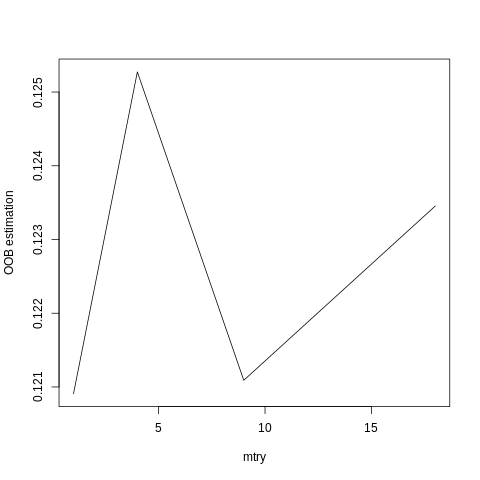

In [61]:
mtrys <- 0:floor(log(ss.lv.nvars, 2))
mtrys <- floor(ss.lv.nvars / (2 ^ mtrys))
cant.mtrys <- length(mtrys)

oob.estimations <- double(cant.mtrys)
for(mtry in 1:cant.mtrys){
  errores.mtry <- double(5)
  for(run in 1:5){
    rf.model <- randomForest(ss.lv.x, as.factor(ss.lv.y), mtry=mtrys[mtry], ntree=1000)
    oob.est <- rf.model$err.rate[1000]
    errores.mtry[run] <- oob.est
  }
  oob.estimations[mtry] <- mean(errores.mtry)
}

cat("mtry óptima: ", mtrys[which.min(oob.estimations)], "Error de la mtry: ", oob.estimations[which.min(oob.estimations)])
plot(mtrys, oob.estimations, type="l", xlab="mtry", ylab="OOB estimation")

## Boosting

In [71]:
ss.lv[,19] <- as.factor(ss.lv[,19]) # si no se rompe boosting()
# hago proporcion 80/20 entre train y test
smp.size <- floor(0.8 * nrow(ss.lv))
train_r <- sample(seq_len(nrow(ss.lv)), size = smp.size)

ss.lv.train <- ss.lv[train_r, ]
ss.lv.test <- ss.lv[-train_r, ]

Profundidad máxima:  17 Error:  0.09545455

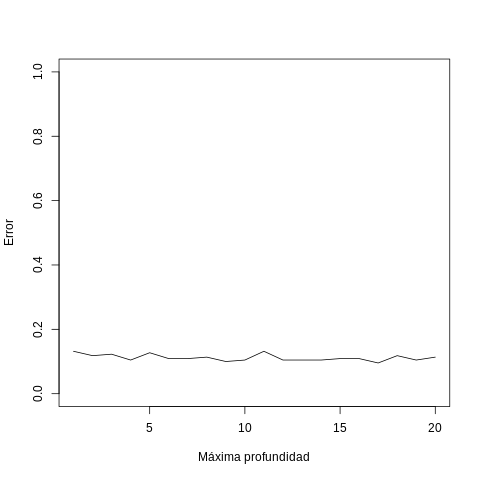

In [72]:
ss.lv.errores <- double(20)

for(depth in 1:20){
  ss.lv.adaboost <- boosting(stress_level ~ ., data = ss.lv.train, mfinal = 200, coef="Freund",
                                control = rpart.control(maxdepth = depth))
  pred <- predict(ss.lv.adaboost, ss.lv.test)
  ss.lv.errores[depth] <- pred$error
}

cat("Profundidad máxima: ", which.min(ss.lv.errores), "Error: ", min(ss.lv.errores))
plot(c(1:20), ss.lv.errores, type="l", xlab="Máxima profundidad", ylab="Error", ylim=c(0,1))

## SVM Radial

In [73]:
# hago proporcion 80/20 entre train y test
smp.size <- floor(0.8 * nrow(ss.lv))
train_r <- sample(seq_len(nrow(ss.lv)), size = smp.size)

ss.lv.train <- ss.lv[train_r, ]
ss.lv.test <- ss.lv[-train_r, ]

In [74]:
ss.lv.errores.overall <- matrix(, nrow = 0, ncol = 3)
colnames(ss.lv.errores.overall) <- c("c","g","Error")

for(c in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3,10^4,10^5)){
  for(g in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3)){
    ss.lv.svm.rbf <- svm(stress_level~., ss.lv.train, kernel="radial", gamma=g, cost=c)
    pred<-predict(ss.lv.svm.rbf, newdata = ss.lv.test)
    error<-1-sum(pred==ss.lv.test[,"stress_level"])/dim(ss.lv.test)[1]
    ss.lv.errores.overall <- rbind(ss.lv.errores.overall, c(c, g, error))
  }
}

df <- as.data.frame(ss.lv.errores.overall)
opt <- df[which.min(df$Error),]
cat("Parámetros óptimos: \n c:", as.numeric(opt[1]), " g: ", as.numeric(opt[2]), " Error: ", as.numeric(opt[3]))

Parámetros óptimos: 
 c: 10000  g:  1e-04  Error:  0.08636364

## SVM Polinomial

In [75]:
# hago proporcion 80/20 entre train y test
smp.size <- floor(0.8 * nrow(ss.lv))
train_r <- sample(seq_len(nrow(ss.lv)), size = smp.size)

ss.lv.train <- ss.lv[train_r, ]
ss.lv.test <- ss.lv[-train_r, ]

In [77]:
ss.lv.errores.overall <- matrix(, nrow = 0, ncol = 3)
colnames(ss.lv.errores.overall) <- c("c","d","Error")

for(c in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3,10^4,10^5)){
  for(d in 1:5){
    ss.lv.svm.pol <- svm(stress_level~., ss.lv.train, kernel="polynomial", degree=d, cost=c)
    pred<-predict(ss.lv.svm.pol, newdata = ss.lv.test)
    error<-1-sum(pred==ss.lv.test[,"stress_level"])/dim(ss.lv.test)[1]
    ss.lv.errores.overall <- rbind(ss.lv.errores.overall, c(c, d, error))
  }
}

df <- as.data.frame(ss.lv.errores.overall)
opt <- df[which.min(df$Error),]
cat("Parámetros óptimos: \n c:", as.numeric(opt[1]), " d: ", as.numeric(opt[2]), " Error: ", as.numeric(opt[3]))

Parámetros óptimos: 
 c: 1  d:  1  Error:  0.1181818

## Comparación de resultados

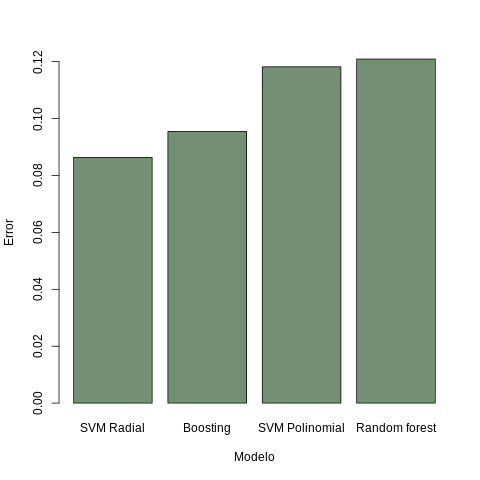

In [78]:
results <- data.frame("Modelo"=c("SVM Radial","Boosting", "SVM Polinomial","Random forest"),
                      "Error"=c(0.08636364, 0.09545455, 0.1181818, 0.1209091))

barplot(height=results$Error, names.arg=results$Modelo, xlab="Modelo", ylab="Error", col = "#739072")

Conclusiones:
- Se obtuvieron muy buenos resultados con todos los métodos, con muy poca diferencia entre ellos
- Sin embargo, por la complejidad de los algoritmos y el tiempo que tardaron en ejecutar, SVM Radial también destaca ya que se ejecutó muy rápido y es el que menor error obtuvo. Boosting fue el más lento de todos, seguido de RF y SVM Polinomial (aunque este no tardó en el orden de Boosting/RF, tampoco estuvo en el orden del SVM Radial).
- En RF obtuvimos una mtry óptima de 1, la cual está bastante cerca de la regla general de la raíz, 4.